## RESNET Ablation Study 
> ablation study :   
논문에서 새롭게 제시한 문제 해결 방법 을 '제거' 한 모델과, 해당 방법을 추가한 모델로 수행한 실험의 결과를 비교하여 제시한 방법이 성능이나 문제 해결에 효과가 있음을 증명하는 연구

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


### 구현 방법 
>block : 딥러닝 모델에서 주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위  
>layer : 기본적으로 tensorflow , keras, pytorch 등에서 기본적으로 제공되는 단위 

- block 단위로 resnet 의 기본 모델을 만든다 
  - resnet -18,34,50,101,152 다섯가지의 네트워크가 가지는 기본 구조는 동일
  - 기본 구조를 먼저 구현하고, 각각 네트워크마다의 특성을 함수 인자로 전달 받아 수정 할 수 있게 한다

### Resnet Main Concept
- residual learning framework to ease the training of networks that are substatially deeper than those used previously
- instead of learning unreferenced functions, reformulate the layers as learning residual functions with reference to the layer inputs
- these residual networks are easier to optimize and can gain accuracy from considerably increased depth <br>

(from abstract of deep residual learning for image Recognition paper )

> 'residual block' 을 이용해서 잔차학습을 진행하는 것이 좀 더 깊은 레이어를 가진 모델을 학습시키는데에 도움이 된다 <br>
> identity mapping 을 다음 레이어로 들어가는 input 에 함께 들어갈 수 있게끔  shortcut 을 사용한다 = reformulate layer <br>
> residual network 는 최적화를 조금 더 쉽게 진행 할 수 있게 하며, 충분히 깊은 모델에서 정확도 향상에도 도움이 된다.

### ResNet 의 Network Architectures
- ResNet34 & 50 
  - conv block 3,4,6,3 개씩 반복해서 쌓은 형태
  - 각각의 cov block 안에 두개 또는 세개의 conv layer 가 들어 가 있음 
- ResNet34 
  - Bock 3x3 kernel 인 conv layer 로 만 구성 
- ResNet 50 
   - ResNet34 의 구성 앞 뒤로 1x1 convolution 이 붙어있음 : bottleneck 현상 

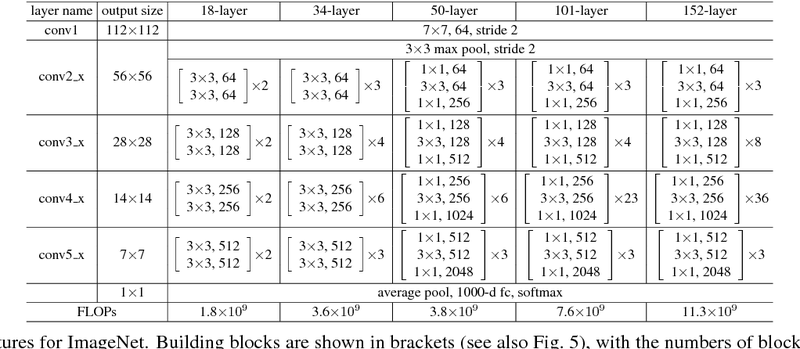

### Resnet Implementation 
plain network 
- baselines are mainly inspired by the philosophy of vGG nets 
- conv layers mostly have 3*3 filters 
- performed downsampling directly by convolutional layers that have stride of 2
- the network ends with the global average pooling layer, 1000 way fully connected layer with softmax
> plain net   
> - vgg net 형식을 따른다   
> - channel 수가 바뀌는 곳에서는 conv / stride 2 를 수행하여 down sample 한다  
> - 네트워크 마지막에 global average pooling 을 사용하고, fc / softmax 를 사용한다


residual network 
- based on the plain network
- inserted shortcut connections 
 - shortcut turns the network into its counterpart residual version
- identity shortcut 
  - directly used when the input and output are of the same dimensions (solid line shortcuts)
  - when the dimensions increase, consider two options (dotted line shortcuts)
    - a. the shortcut still performs identity mapping with extra zero padded for increaseing dimensions  
    - b. the projection shortcut is used to match dimensions ( done by 1*1 conv)
    - eitherway we used stride 2 for shortcuts 

> residual network   
> - plain network + shortcut 
> - input 과 output 이 같을 경우 identity shortcut 을 direct 하게 사용(실선 shortcut)  
> - 채널 수 가 증가할 경우(점선 shortcut) 
    - identity mapping 이지만 zero padding 을 이용해 채널을 맞춰준다
    - projection shortcut 의 경우 conv 1*1 을 사용한다
    - 두 가지 모두 stride 는 2 를 준다 

implementation
- image is resized with its shorter side randomly sampled in [256,480] for scale augmentation
- adopt batch normalization right after each convolution and before activation
- initialize the weights (using he-normal) and train all plain/residual nets from scratch
- used SGD with mini-batch size of 256 
- learing rate starts from 0.1 and is divided by 10 when the error plateaus
- weight decay of 0.0001 , momentum of 0.9
- do not use dropout

> implementation  
> - 이미지는 짧은 쪽을 기준으로 랜덤하게 [256,480] 사이즈로 augmentation 을 한다 (사용하는 데이터 셋이 달라 적용하지 않음)  
> - 매번 conv 레이어를 지날 때 마다 batch normalrization 을 activation(ReLu) 이전에 수행한다  
> - weight 을 initialize 하며, 학습이 되지 않은 상태부터 시작해, SGD 를 이용해 train 을 진행한다  
> - learning rate 는 0.1 에서 시작하여 에러가 평평해질 때 1//10 을 해준다 (구현하는 방법을 몰라서 적용하지 않음)  
> - weight decay 0.0001 ( 확실하게 이해하지 못했지만, L2 무언가를 사용) / momentum 0.9 ( 최적화 함수에서 사용)  
> - dropout 은 사용하지 않음 

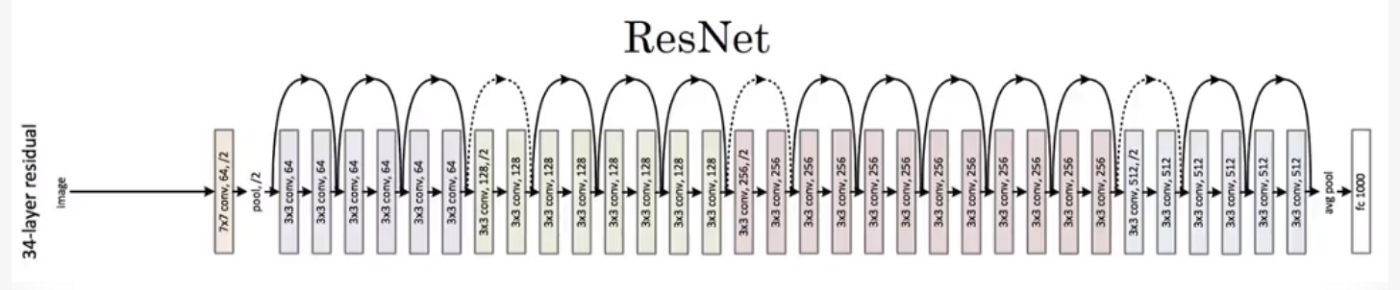

#### 1. 기본 블럭 구현하기 

In [ ]:
def build_resnet_block(input_layer, num_cnn=3,channel=64,block_num=0,is_50=False,plain=False):

  # input layer 를 x 와 shortcut 에 각각 저장 해 준다 
  # x 는 layer 들을 지나 연산이 진행되고, shortcut 은 skip connection 에서 사용된다 
  x = input_layer 
  shortcut = input_layer
  stride = 1 
  # shortcut 의 종류에 따라 stride 가 1 또는 2 로 변하기 때문에 stride 라는 변수 생성 
 
  # for resnet 50
  if is_50 == True :  
    for cnn_num in range(num_cnn):
      # dotted shortcut 은 아니지만, channel 수를 맞추어 주기 위함 block 2_ 0 인 경우 딱 한번 사용됨 
      if block_num ==2 and cnn_num == 0:
        shortcut = keras.layers.Conv2D(filters=channel*4,kernel_size=1, strides=1,name=f"shortcut_{block_num}_{cnn_num}")(input_layer)
        shortcut = keras.layers.BatchNormalization(name=f'shortcut_bn_{block_num}_{cnn_num}')(shortcut)

      # different dimension 에서 발생하는 dotted line shortcut 을 위함 
      # block3_0 , block4_0, block5_0 에서 발생함 
      if block_num != 2 and cnn_num == 0:
        stride =2
        shortcut = keras.layers.Conv2D(filters=channel*4,kernel_size=1, strides=stride,name=f"shortcut_{block_num}_{cnn_num}")(input_layer)
        shortcut = keras.layers.BatchNormalization(name=f'shortcut_bn_{block_num}_{cnn_num}')(shortcut)

      y = keras.layers.Conv2D(filters=channel, kernel_size=1,kernel_initializer='he_normal',padding='same',strides=stride,name=f'block{block_num}_{cnn_num}_conv1')(x)
      y = keras.layers.BatchNormalization(name=f'bolck{block_num}_{cnn_num}_bn1')(y)
      y = keras.activations.relu(y)

      y = keras.layers.Conv2D(filters=channel, kernel_size=(3,3),kernel_initializer='he_normal',padding='same',strides=1,name=f'block{block_num}_{cnn_num}_conv2')(y)
      y = keras.layers.BatchNormalization(name=f'bolck{block_num}_{cnn_num}_bn2')(y)
      y = keras.activations.relu(y)

      # 3rd conv 에서 channel *4 
      y = keras.layers.Conv2D(filters=channel*4, kernel_size=1,kernel_initializer='he_normal',padding='same',strides=1,name=f'block{block_num}_{cnn_num}_conv3')(y)
      y = keras.layers.BatchNormalization(name=f'bolck{block_num}_{cnn_num}_bn3')(y)

      # print(block_num,cnn_num) -> for debuging

      # for plain net 50 
      if not plain :
        z = keras.layers.Add(name=f'bolck{block_num}_{cnn_num}_shortcut')([y,shortcut])
        z = keras.activations.relu(z)
        shortcut = z # 다음 shortcut 을 위해 z 값으로 shorcut 업데이트
      else : 
        z = keras.activations.relu(y)

      x = z  # 최초 input layer 가 아닌 연산을 거친 결과값이 다시 input 으로 들어가야 함 -> x 를 z 로 업데이트 
      stride = 1 # stride 도 다시 돌려줌 
  


  # for resnet 34
  else :
    for cnn_num in range(num_cnn):
      if block_num != 2 and cnn_num == 0:
        stride =2
        shortcut = keras.layers.Conv2D(filters=channel,kernel_size=1, strides=2,name=f"shortcut_{block_num}_{cnn_num}")(input_layer)
        shortcut = keras.layers.BatchNormalization(name=f'shortcut_bn_{block_num}_{cnn_num}')(shortcut)

      y = keras.layers.Conv2D(filters=channel, kernel_size=(3,3),kernel_initializer='he_normal',padding='same',strides=stride,name=f'block{block_num}_{cnn_num}_conv1')(x)
      y = keras.layers.BatchNormalization(name=f'bolck{block_num}_{cnn_num}_bn1')(y)
      y = keras.activations.relu(y)

      y = keras.layers.Conv2D(filters=channel, kernel_size=(3,3),kernel_initializer='he_normal',padding='same',strides=1,name=f'block{block_num}_{cnn_num}_conv2')(y)
      y = keras.layers.BatchNormalization(name=f'bolck{block_num}_{cnn_num}_bn2')(y)

      # print(block_num,cnn_num)
      # for plain net 34
      if not plain :
        z = keras.layers.Add(name=f'bolck{block_num}_{cnn_num}_shortcut')([y,shortcut])
        z = keras.activations.relu(z)
        shortcut = z
      else :
        z = keras.activations.relu(y)
        
      x = z 
      stride = 1

  return z

  

#### 2. input layer 가 기본 블럭에 들어가기 전에 수행되는 연산을 함수로 만듬

In [ ]:
# block 1 에서 일어나는 일 + block 2_0 이전에 필요한 maxpooling 
def build_resnet_input_layer(input_layer):
  y = input_layer
  
  y = keras.layers.Conv2D(filters=64,kernel_size=(7,7),strides=2,padding='same')(y)
  y = keras.layers.BatchNormalization()(y)
  y = keras.activations.relu(y)
  
  y = keras.layers.MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(y)

  return y

#### 3. 기본 블럭과 input layer 함수를 이용해 전체 resnet 구현하는 함수 

In [ ]:
def create_resnet(input_shape=(32,32,3),num_cnn_list=[3,4,6,3],channel_list=[64,128,256,512],num_classes=10,is_50=False,plain=False):

  assert len(num_cnn_list) == len(channel_list)

  input_layer = keras.layers.Input(shape=input_shape)
  output = build_resnet_input_layer(input_layer)
  # output = input_layer

  for i, (num_cnn, channel) in enumerate(zip(num_cnn_list,channel_list)):
    output = build_resnet_block(output, num_cnn=num_cnn,channel=channel,block_num=i+2,is_50=is_50,plain=plain)

  output = keras.layers.GlobalAveragePooling2D()(output)  # 중요 ! average pooling 은 안됨 ! 
  output = keras.layers.Flatten()(output)
  # kernel_regularizer : for weight decay (l2 norm)
  output = keras.layers.Dense(num_classes, activation='softmax',
                              kernel_regularizer=tf.keras.regularizers.l2(0.0001))(output)


  model = keras.Model(inputs=input_layer,outputs=output)

  return model

- resnet 34

In [ ]:
resnet_34 = create_resnet(input_shape=(224,224,3),num_classes=2)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

- resnet 50

In [ ]:
resnet_50 = create_resnet(input_shape=(224,224,3),num_classes=2,is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 112, 112, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                           

#### 4. 기본 블럭과 input layer 함수를 이용하여 plain net 구현하는 함수 

In [ ]:
def create_plainnet(input_shape=(32,32,3),num_cnn_list=[3,4,6,3],channel_list=[64,128,256,512],num_classes=10,is_50=False,plain=True):

  assert len(num_cnn_list) == len(channel_list)

  input_layer = keras.layers.Input(shape=input_shape)
  output = build_resnet_input_layer(input_layer)
  # output = input_layer

  for i, (num_cnn, channel) in enumerate(zip(num_cnn_list,channel_list)):
    output = build_resnet_block(output, num_cnn=num_cnn,channel=channel,block_num=i+2,is_50=is_50,plain=plain)

  output = keras.layers.GlobalAveragePooling2D()(output)
  output = keras.layers.Flatten()(output)
  output = keras.layers.Dense(num_classes, activation='softmax',
                              kernel_regularizer=tf.keras.regularizers.l2(0.0001))(output)

  model = keras.Model(inputs=input_layer,outputs=output)

  return model

- plain net 34

In [ ]:
plainnet_34 = create_plainnet(input_shape=(224,224,3),num_classes=2)
plainnet_34.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_2 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 tf.nn.relu_82 (TFOpLambda)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 block2_0_conv1 (Conv2D)     (None, 56, 56, 64)        3692

- plain net 50

In [ ]:
plainnet_50 = create_plainnet(input_shape=(224,224,3),num_classes=2,is_50=True)
plainnet_50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_3 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 tf.nn.relu_115 (TFOpLambda)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 block2_0_conv1 (Conv2D)     (None, 56, 56, 64)        4160

#### 5. 학습에 사용할 데이터 불러오기 
- tensorflow dataset 에 있는 cats_vs_dogs
  - 마지막 dense layer 에서 numclass = 2 
  - [224,224] 로 resize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
import urllib3
urllib3.disable_warnings()

# tfds.disable_progress_bar()

(ds_train,da_test), ds_info = tfds.load('cats_vs_dogs',split=['train[:80%]','train[80%:]'],shuffle_files=True, with_info=True)

In [ ]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
  ds = ds.map(normalize_and_resize_img, num_parallel_calls=1)
  ds = ds.batch(batch_size)
  if not is_test: 
    ds = ds.repeat()
    ds = ds.shuffle(200)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [ ]:
ds_info.features['label'].names

['cat', 'dog']

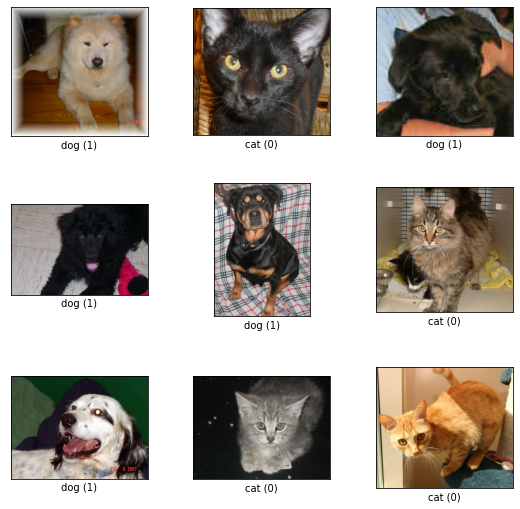

In [ ]:
fig = tfds.show_examples(ds_train,ds_info)

#### 6. 학습 진행하기

In [ ]:
BATCH_SIZE = 32
EPOCH = 50

In [ ]:
(ds_train,ds_test), ds_info = tfds.load('cats_vs_dogs',split=['train[:80%]','train[80%:]'],as_supervised=True,shuffle_files=True, with_info=True)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

- resnet train

In [ ]:
resnet_34.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
    metrics=['accuracy']

)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 134s 205ms/step - loss: 0.6704 - accuracy: 0.6107 - val_loss: 0.6392 - val_accuracy: 0.6483
Epoch 2/50
581/581 [==============================] - 120s 207ms/step - loss: 0.5928 - accuracy: 0.6856 - val_loss: 0.6888 - val_accuracy: 0.6015
Epoch 3/50
581/581 [==============================] - 123s 211ms/step - loss: 0.5404 - accuracy: 0.7302 - val_loss: 0.5564 - val_accuracy: 0.7117
Epoch 4/50
581/581 [==============================] - 123s 212ms/step - loss: 0.4720 - accuracy: 0.7688 - val_loss: 0.7893 - val_accuracy: 0.6483
Epoch 5/50
581/581 [==============================] - 124s 213ms/step - loss: 0.4249 - accuracy: 0.8034 - val_loss: 0.7424 - val_accuracy: 0.6582
Epoch 6/50
581/581 [==============================] - 123s 212ms/step - loss: 0.3684 - accuracy: 0.8320 - val_loss: 0.5427 - val_accuracy: 0.7478
Epoch 7/50
581/581 [==============================] - 124s 213ms/step - loss: 0.2988 - accuracy: 0.8716 - val_loss: 0.8845 - val_accura

In [ ]:
resnet_50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
    metrics=['accuracy']

)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 235s 383ms/step - loss: 0.8272 - accuracy: 0.5442 - val_loss: 1.1610 - val_accuracy: 0.5678
Epoch 2/50
581/581 [==============================] - 221s 381ms/step - loss: 0.7319 - accuracy: 0.6183 - val_loss: 0.8533 - val_accuracy: 0.6019
Epoch 3/50
581/581 [==============================] - 220s 379ms/step - loss: 0.7182 - accuracy: 0.6486 - val_loss: 0.7277 - val_accuracy: 0.6902
Epoch 4/50
581/581 [==============================] - 221s 381ms/step - loss: 0.6132 - accuracy: 0.6961 - val_loss: 0.7562 - val_accuracy: 0.6660
Epoch 5/50
581/581 [==============================] - 221s 381ms/step - loss: 0.5813 - accuracy: 0.7134 - val_loss: 0.7034 - val_accuracy: 0.6881
Epoch 6/50
581/581 [==============================] - 221s 381ms/step - loss: 0.5653 - accuracy: 0.7346 - val_loss: 0.8170 - val_accuracy: 0.7039
Epoch 7/50
581/581 [==============================] - 221s 381ms/step - loss: 0.5594 - accuracy: 0.7421 - val_loss: 0.7693 - val_accura

#### 7. resnet34 vs resnet 50 
- resnet 34 가 수렴 속도도 더 빠르고 정확도도 조금 좋게 나왔다

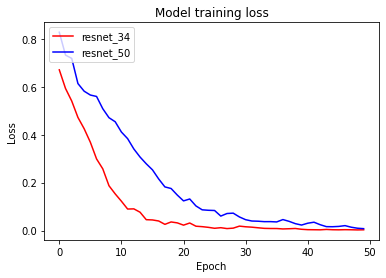

In [ ]:
plt.plot(history_34.history['loss'],'r')
plt.plot(history_50.history['loss'],'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34','resnet_50'],loc='upper left')
plt.show()

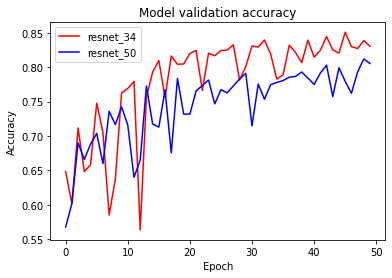

In [ ]:
plt.plot(history_34.history['val_accuracy'],'r')
plt.plot(history_50.history['val_accuracy'],'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34','resnet_50'],loc='upper left')
plt.show()

- plain net train

In [ ]:
plainnet_34.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
    metrics=['accuracy']

)

history_plain_34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 127s 203ms/step - loss: 0.6987 - accuracy: 0.5377 - val_loss: 0.7039 - val_accuracy: 0.5655
Epoch 2/50
581/581 [==============================] - 118s 202ms/step - loss: 0.6787 - accuracy: 0.5801 - val_loss: 0.7378 - val_accuracy: 0.5593
Epoch 3/50
581/581 [==============================] - 118s 203ms/step - loss: 0.6473 - accuracy: 0.6286 - val_loss: 0.6452 - val_accuracy: 0.6412
Epoch 4/50
581/581 [==============================] - 118s 203ms/step - loss: 0.6197 - accuracy: 0.6566 - val_loss: 0.6085 - val_accuracy: 0.6749
Epoch 5/50
581/581 [==============================] - 118s 203ms/step - loss: 0.5970 - accuracy: 0.6785 - val_loss: 0.6088 - val_accuracy: 0.6821
Epoch 6/50
581/581 [==============================] - 118s 203ms/step - loss: 0.5761 - accuracy: 0.6958 - val_loss: 0.5917 - val_accuracy: 0.6893
Epoch 7/50
581/581 [==============================] - 118s 203ms/step - loss: 0.5495 - accuracy: 0.7198 - val_loss: 0.5476 - val_accura

In [ ]:
plainnet_50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
    metrics=['accuracy']

)

history_plain_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 189s 308ms/step - loss: 0.7076 - accuracy: 0.5202 - val_loss: 0.6979 - val_accuracy: 0.5179
Epoch 2/50
581/581 [==============================] - 179s 308ms/step - loss: 0.6983 - accuracy: 0.5550 - val_loss: 0.6918 - val_accuracy: 0.5636
Epoch 3/50
581/581 [==============================] - 179s 309ms/step - loss: 0.6753 - accuracy: 0.6005 - val_loss: 0.6482 - val_accuracy: 0.6323
Epoch 4/50
581/581 [==============================] - 179s 309ms/step - loss: 0.6530 - accuracy: 0.6310 - val_loss: 0.6475 - val_accuracy: 0.6381
Epoch 5/50
581/581 [==============================] - 179s 309ms/step - loss: 0.6342 - accuracy: 0.6518 - val_loss: 0.6251 - val_accuracy: 0.6515
Epoch 6/50
581/581 [==============================] - 180s 309ms/step - loss: 0.6281 - accuracy: 0.6547 - val_loss: 0.6247 - val_accuracy: 0.6565
Epoch 7/50
581/581 [==============================] - 179s 308ms/step - loss: 0.6069 - accuracy: 0.6732 - val_loss: 0.6539 - val_accura

#### 8. Plain net 34 vs Plain net 50
- plain net 34 가 수렴 속도도 빠르고 accuracy 도 더 높다

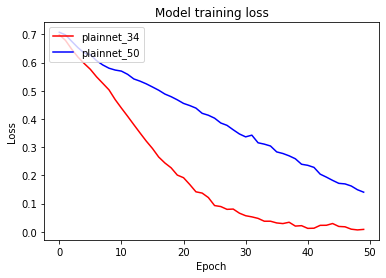

In [ ]:
plt.plot(history_plain_34.history['loss'],'r')
plt.plot(history_plain_50.history['loss'],'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plainnet_34','plainnet_50'],loc='upper left')
plt.show()

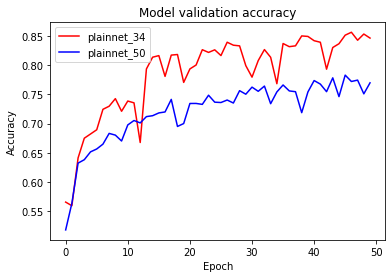

In [ ]:
plt.plot(history_plain_34.history['val_accuracy'],'r')
plt.plot(history_plain_50.history['val_accuracy'],'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plainnet_34','plainnet_50'],loc='upper left')
plt.show()

#### 9. Resnet vs Plainnet 

- resnet 34 vs plain net34
  - loss 수렴 속도에 있어서는 resnet 이 더 좋은 성능을 보인다
  - accuracy 는 막상막하 비슷하게 진행되는 모습을 확인 할 수 있다

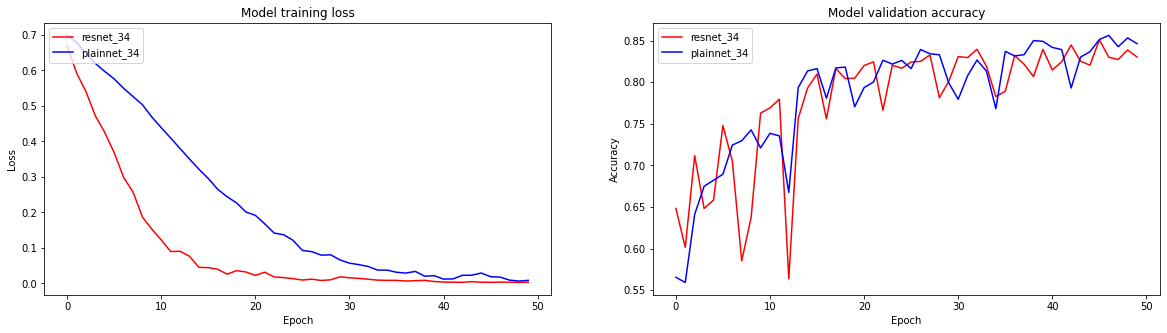

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history_34.history['loss'],'r')
plt.plot(history_plain_34.history['loss'],'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34','plainnet_34'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_34.history['val_accuracy'],'r')
plt.plot(history_plain_34.history['val_accuracy'],'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34','plainnet_34'],loc='upper left')

plt.show()

- resnet 50 vs plain net 50
  - loss 의 수렴 속도와 accuracy 모두 resnet 50 이 더 좋은 성능을 보였다

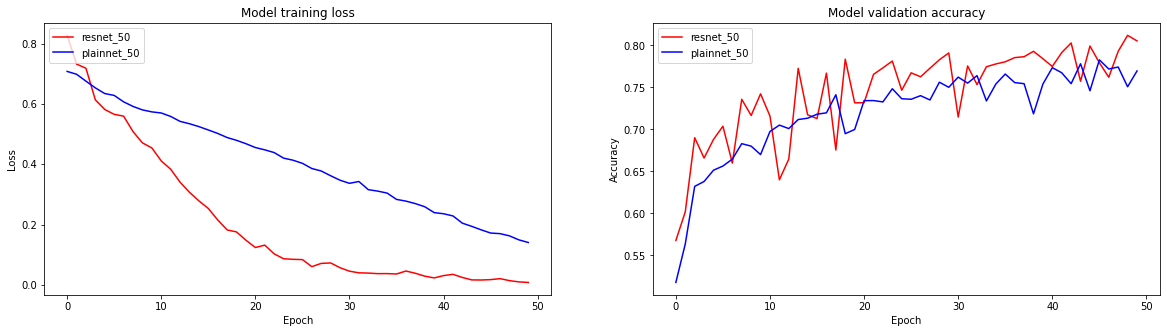

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history_50.history['loss'],'r')
plt.plot(history_plain_50.history['loss'],'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50','plainnet_50'],loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_50.history['val_accuracy'],'r')
plt.plot(history_plain_50.history['val_accuracy'],'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50','plainnet_50'],loc='upper left')

plt.show()

기대한 것 만큼의 드라마틱한 성능의 차이는 확인 하지 못했지만, 결과적으로 resnet 이 근사한 값으로라도 plain net 보다 성능이 좋음을 확인 할 수 있었다 
- 논문에서는 deep enough 한 모델에서 error rate 가 개선됨을 강조했다
- 따라서 error rate 를 확인 해 보면 성능 차이를 조금 더 선명하게 확인 할 수 있지 않을까 하는 생각이 든다 ( 하지만,, 어떻게 하는지 아직 모른다,,)
- 학습에서 사용한 데이터셋이 논문에서 사용한 데이터 셋과 다른데, 같은 optimizer 와 learning rate, momentum 등 이외 학습에 사용되는 parameter 들을 사용한 것이 오히려 역효과가 날 수도 있지 않을까 싶기도 하다
- 인력 부족, 시간 부족 으로 인해 더 많은 에폭을 돌리지 못한점, 여러가지 데이터셋과 여러 parameter 등을 시도해 보지 못한 점 등이 아쉽고, 그렇게 했더라면 더 확실한 결과를 얻을 수 도 있지 않을까 하는 생각이 든다